### Credit card default data set from UCI-ML Repository [link to dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)
#### A classification problem with: 
- 30,000 client data, 
- 23 variables (or inputs), 
- 1 binary output: Default payment (Yes=1, No=0)
- no missing values

### PROBLEM STATEMENT: Predict the probability that a client will default

In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 16})
import seaborn as sns

### Import the data, scale and split in train-test datasets

In [2]:
##############################################################################################################
# Import data and rename column
cc_data = pd.read_excel('cc_data_uci.xls')
cc_data.rename(columns={'default payment next month': 'OUTPUT'}, inplace = True)

# Separate inputs: X and output:y
X = cc_data.drop(['OUTPUT'], axis = 1)
y = cc_data['OUTPUT']

##############################################################################################################
# Create the instance of the scaler
scaler = StandardScaler()
# Transform the inputs X
X_scaled = scaler.fit_transform(X)
X_scaled.mean(axis=0)

##############################################################################################################
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=2/3, random_state=0)

## [An overview of Support Vector Machines in Sklearn](https://scikit-learn.org/stable/modules/svm.html)
### Next, we will explore 2 Sklearn versions: the simple [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [3]:
# Start with default values to show issues in convergence
# linear_sv = svm.LinearSVC(random_state=23)
linear_sv = svm.LinearSVC(C = 0.1, random_state=23, max_iter=2000)
linear_sv.fit(X_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=23, tol=0.0001,
          verbose=0)

In [4]:
m = linear_sv.coef_

In [5]:
linear_sv.intercept_

array([-0.55616706])

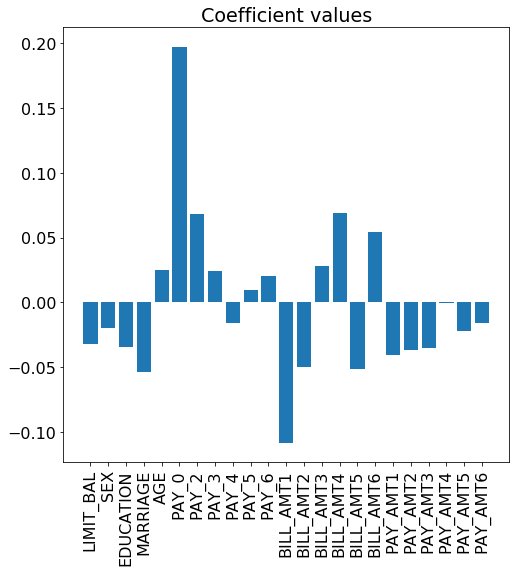

In [6]:
# Create plot
plt.figure()
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(X.shape[1]), m[0])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
# Show plot
plt.show()

#### SVM methods in Sklearn do not calculate probabilities since they do not fit between 0 and 1 like Logistic Regression (SVM is not a **probabilistic** modeling method).
#### Instead, in order to **quantify** the confidence of a sample, SVM methods use the **distance from the hyperplane**.
#### The distance of a sample from the hyperplane is calculated with the method **decision_function** and is called **confidence score**.

Text(8.280000000000001, 0.5, 'Counts of clients')

<Figure size 360x360 with 0 Axes>

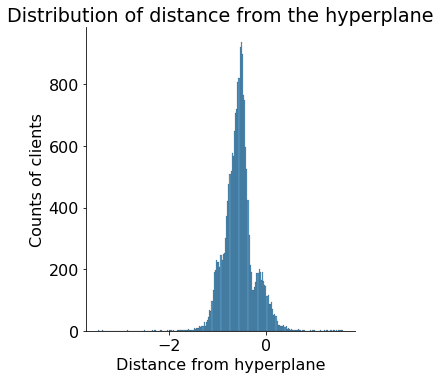

In [7]:
y_test_distance = linear_sv.decision_function(X_test)
y_test_distance.shape
plt.figure(figsize=(5,5))
sns.displot(data = y_test_distance, x = y_test_distance)
plt.title('Distribution of distance from the hyperplane')
plt.xlabel('Distance from hyperplane')
plt.ylabel('Counts of clients')

### Let's plot the decision boundary of the Linear SVM **(refer to notebook: 02_cards_LogReg for code details)**

In [8]:
xx, yy = np.mgrid[-2:8:1.1111, -3:13:1.75] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape # Confirm that grid shape is 10x10

# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 23)) * np.median(X_train, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,5] = grid[:,0]
median_inputs[:,11] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,:12] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 5)|(x.name == 11)  else '' for i in x])


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,-3.000000
1,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,-1.250000
2,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,0.500000
3,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,2.250000
4,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,4.000000
5,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,5.750000
6,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,7.500000
7,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,9.250000
8,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,11.000000
9,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,12.750000


In [9]:
distance_linear = linear_sv.decision_function(median_inputs).reshape(xx.shape)

[(-3, 13),
 Text(0, 0.5, 'BILL_AMT1 scaled'),
 (-2, 8),
 Text(0.5, 0, 'PAY_0 scaled'),
 None]

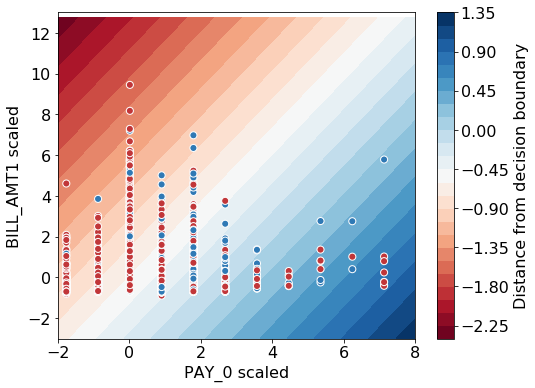

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, distance_linear, 25, cmap="RdBu",
                      vmin=distance_linear.min(), vmax=distance_linear.max())
ax_c = f.colorbar(contour)
ax_c.set_label("Distance from decision boundary")

ax.scatter(X_train[50:,5], X_train[50:, 11], c=y_train[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 8), ylim=(-3, 13),
       xlabel="PAY_0 scaled", ylabel="BILL_AMT1 scaled")

#### The decision boundary is where the distance is zero.
#### **REMARKS:** Compare the decision boundary and the contour with the one from Logistic Regression. What do you observe?
#### **1.** Check the respective intercept values on the graphs
#### **2.** SVM's contour is linear the LogReg contour is more steep (since it follow the sigmoid function)



### Some basic performance metrics: The confusion matrix

In [11]:
y_test_predicted = linear_sv.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted)
print(cm)

[[15383   254]
 [ 3639   724]]


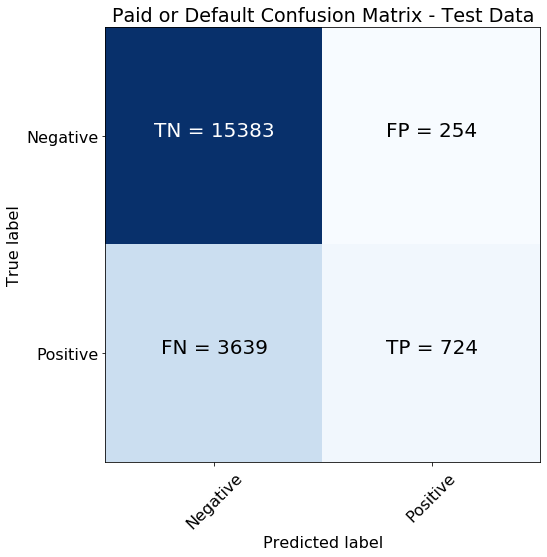

In [12]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

### The more generic function [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) allows us to implement more complex decision boundaries.
### Let's start with the default kernel, the Radial Basis Function or rbf defined by the function: $exp\left(-\gamma \|x-x'\|^2\right)$
### Parameters C and $\gamma$ are the two parameters we tune to optimize RBF kernels. C will be discussed later with the LASSO methods.

In [13]:
# Start with default values to show issues in convergence
# rbf_sv = svm.SVC(random_state=23)
rbf_sv = svm.SVC(C = 1.0, gamma=0.1, random_state=23, max_iter=10000, class_weight={0: 1, 1: 4}) # class_weight='balanced' 
rbf_sv.fit(X_train, y_train)

C:\Users\nikan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0: 1, 1: 4},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=10000, probability=False, random_state=23, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
# Indices of support vector. Looks like way to many. How many?
rbf_sv.support_

array([   0,    3,    5, ..., 9968, 9979, 9996])

In [15]:
# Number of support vectors for each class. 2,296 out of 20,000 points roughly are support vectors!!!
rbf_sv.n_support_

array([5472, 1686])

[(-3, 13),
 Text(0, 0.5, 'BILL_AMT1 scaled'),
 (-2, 8),
 Text(0.5, 0, 'PAY_0 scaled'),
 None]

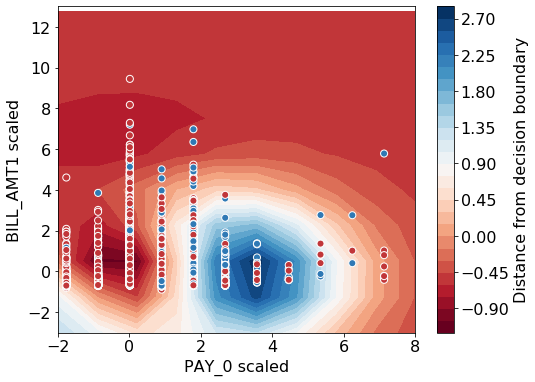

In [16]:
distance_rbf = rbf_sv.decision_function(median_inputs).reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, distance_rbf, 25, cmap="RdBu",
                      vmin=distance_rbf.min(), vmax=distance_rbf.max())
ax_c = f.colorbar(contour)
ax_c.set_label("Distance from decision boundary")

ax.scatter(X_train[50:,5], X_train[50:, 11], c=y_train[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 8), ylim=(-3, 13),
       xlabel="PAY_0 scaled", ylabel="BILL_AMT1 scaled")

### Let's also use the [polynomial kernel](https://en.wikipedia.org/wiki/Polynomial_kernel#:~:text=In%20machine%20learning%2C%20the%20polynomial%20kernel%20is%20a,the%20original%20variables%2C%20allowing%20learning%20of%20non-linear%20models.) defined by the function: $\left(\gamma \langle x,x' \rangle + r\right)^d$, where d value is typically 2
<img src="polynomial_kernel.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

In [17]:
# Start with default values to show issues in convergence
# poly_sv = svm.SVC(random_state=23)
poly_sv = svm.SVC(C = 0.1, kernel='poly', degree=2, coef0=1, gamma=0.1, random_state=23, max_iter=10000, class_weight={0: 1, 1: 4}) # class_weight='balanced' 
poly_sv.fit(X_train, y_train)

C:\Users\nikan\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight={0: 1, 1: 4}, coef0=1,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',
    max_iter=10000, probability=False, random_state=23, shrinking=True,
    tol=0.001, verbose=False)

[(-3, 13),
 Text(0, 0.5, 'BILL_AMT1 scaled'),
 (-2, 8),
 Text(0.5, 0, 'PAY_0 scaled'),
 None]

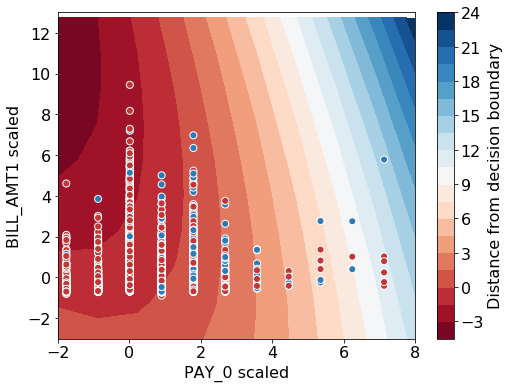

In [18]:
distance_poly = poly_sv.decision_function(median_inputs).reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, distance_poly, 25, cmap="RdBu",
                      vmin=distance_poly.min(), vmax=distance_poly.max())
ax_c = f.colorbar(contour)
ax_c.set_label("Distance from decision boundary")

ax.scatter(X_train[50:,5], X_train[50:, 11], c=y_train[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 8), ylim=(-3, 13),
       xlabel="PAY_0 scaled", ylabel="BILL_AMT1 scaled")

### **FINAL NOTES:** Although SVM were particularly popular in the 90s and 00s, the compute and storage increases rapidly with large samples and features (N,k). The reason is that the quadratic programming program (QP) scales between $O\left(n_{features} \times n^2_{samples}\right)$ and $O\left(n_{features} \times n^3_{samples}\right)$ and you typically see convergence issues for more than 10,000 samples.
### The **LinearSVC** is much more efficient than the different kernels.
### Scaling of the data is crucial.
### Balancing the data or defining the 4:1 weight for the under-represented class of 1 may help convergence.